In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    ExpandingWindowSplitter,
)
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_evaluation import evaluate
from sklearn.neural_network import MLPRegressor

In [2]:
df = pd.read_excel(r'C:\Users\kosta\Documents\PhD related\Python\Feature forecasting\All metals.xlsx',parse_dates = ['DATE'],index_col='DATE')

In [3]:
#df.index = pd.PeriodIndex(df.index, freq="M")

In [4]:
copper = df['COPPER'].to_frame()

In [5]:
copper

,COPPER
DATE,
1990-01-01,2366.64
1990-02-01,2360.16
1990-03-01,2625.61
1990-04-01,2686.15
1990-05-01,2741.95
...,...
2022-08-01,7981.84
2022-09-01,7746.01
2022-10-01,7651.08


In [6]:
y_train, y_test = temporal_train_test_split(copper.iloc[:,0],test_size=12)
y_train = y_train.to_frame()
y_test = y_test.to_frame()

In [7]:
y_train

,COPPER
DATE,
1990-01-01,2366.64
1990-02-01,2360.16
1990-03-01,2625.61
1990-04-01,2686.15
1990-05-01,2741.95
...,...
2021-08-01,9370.14
2021-09-01,9324.71
2021-10-01,9829.22


In [8]:
def temporal(df,periods_to_aggregate):
    df1 = df.copy()
    while len(df1)%periods_to_aggregate != 0:
            df1 = df1.drop(df1.index[0])
    
    df1[str(periods_to_aggregate)] = np.nan
    for i in range(len(df1),0,-periods_to_aggregate):
        df1[str(periods_to_aggregate)].iloc[i-1] = df1[df1.columns[0]].iloc[i-periods_to_aggregate:i].mean()

        
    return df1
            
    

In [9]:
for i in [2,3,4,6,12]:
    copper_temp = temporal(copper.iloc[:-12,0].to_frame(),i)
    copper['agg'+str(i)] = copper_temp.iloc[:,1]
copper.tail(25)

,COPPER,agg2,agg3,agg4,agg6,agg12
DATE,,,,,,
2020-12-01,7772.24,7420.575,7184.986667,7064.9650,6855.210,6173.770833
2021-01-01,7972.15,NaN,NaN,NaN,NaN,NaN
2021-02-01,8470.94,8221.545,NaN,NaN,NaN,NaN
2021-03-01,8988.25,NaN,8477.113333,NaN,NaN,NaN
2021-04-01,9324.82,9156.535,NaN,8689.0400,NaN,NaN
2021-05-01,10161.97,NaN,NaN,NaN,NaN,NaN
2021-06-01,9631.50,9896.735,9706.096667,NaN,9091.605,NaN
2021-07-01,9450.82,NaN,NaN,NaN,NaN,NaN
2021-08-01,9370.14,9410.480,NaN,9653.6075,NaN,NaN


In [10]:
y_train, y_test = temporal_train_test_split(copper,test_size=12)
y_train.tail()

,COPPER,agg2,agg3,agg4,agg6,agg12
DATE,,,,,,
2021-08-01,9370.14,9410.480,NaN,9653.6075,NaN,NaN
2021-09-01,9324.71,NaN,9381.89,NaN,NaN,NaN
2021-10-01,9829.22,9576.965,NaN,NaN,NaN,NaN
2021-11-01,9728.90,NaN,NaN,NaN,NaN,NaN
2021-12-01,9551.18,9640.040,9703.10,9608.5025,9542.495,9317.05


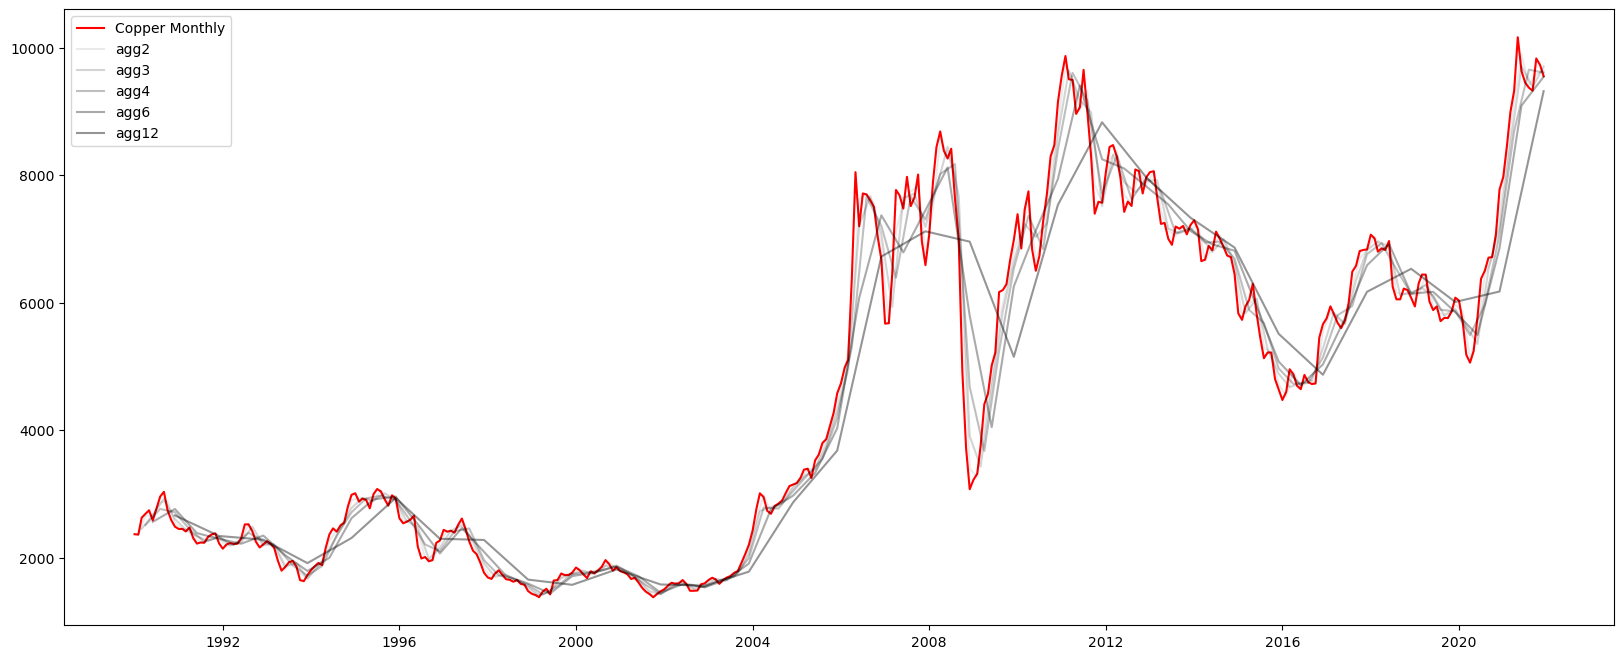

In [11]:
plt.figure(figsize=(20,8))
plt.plot(y_train['COPPER'],c='red',label = 'Copper Monthly')
for i in range(1,len(y_train.columns)):
    plt.plot(y_train.iloc[:,i].dropna(), alpha=i/12,color='black',label=y_train.iloc[:,i].name)
plt.legend()

In [12]:
y_train.iloc[:,1].dropna()

DATE
1990-02-01    2363.400
1990-04-01    2655.880
1990-06-01    2663.255
1990-08-01    2863.260
1990-10-01    2887.465
                ...   
2021-04-01    9156.535
2021-06-01    9896.735
2021-08-01    9410.480
2021-10-01    9576.965
2021-12-01    9640.040
Name: agg2, Length: 192, dtype: float64

In [13]:
horizon = pd.date_range(y_train.index[-1],y_test.index[-1],freq='1MS')[1::1]
horizon

DatetimeIndex(['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [14]:
forecast_all = pd.DataFrame()
forecaster = AutoETS(auto=True,)

In [15]:
forecaster.fit(y_train.iloc[:,0].dropna().values)

AutoETS(auto=True)

In [16]:
horizon = pd.date_range(y_test.index[0],y_test.index[-1],freq='MS')[0::1]
horizon

DatetimeIndex(['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [17]:
fh = ForecastingHorizon(np.arange(len(horizon)), is_relative=True)

In [18]:
pd.Series(forecaster.predict(fh).flatten())

0     9764.921467
1     9525.719955
2     9505.334820
3     9489.026712
4     9475.980226
5     9465.543036
6     9457.193285
7     9450.513484
8     9445.169643
9     9440.894570
10    9437.474512
11    9434.738466
dtype: float64

In [19]:
forecast_all['Monthly'] = pd.Series(forecaster.predict(fh).flatten(),index=horizon)
forecast_all

,Monthly
2022-01-01,9764.921467
2022-02-01,9525.719955
2022-03-01,9505.334820
2022-04-01,9489.026712
2022-05-01,9475.980226
2022-06-01,9465.543036
2022-07-01,9457.193285
2022-08-01,9450.513484
2022-09-01,9445.169643
2022-10-01,9440.894570


In [20]:
#forecast_all = pd.DataFrame(index=y_test.index)
forecaster = AutoETS(auto=True,)
forecaster.fit(y_train.iloc[:,1].dropna().values)
horizon = pd.date_range(y_test.index[0],y_test.index[-1],freq='MS')[1::2]
fh = np.arange(len(horizon))
forecast_all['Monthly'] = pd.Series(forecaster.predict(fh).flatten(),index=horizon)
forecast_all

,Monthly
2022-01-01,NaN
2022-02-01,9576.948356
2022-03-01,NaN
2022-04-01,9640.033691
2022-05-01,NaN
2022-06-01,9640.033691
2022-07-01,NaN
2022-08-01,9640.033691
2022-09-01,NaN
2022-10-01,9640.033691


In [21]:
pd.date_range(y_test.index[-1],y_test.index[-1],freq='MS')[0::6]

DatetimeIndex(['2022-12-01'], dtype='datetime64[ns]', freq='6MS')

In [22]:
forecast_all = pd.DataFrame()
for i,j in zip(range(len(y_train.columns)),range(1,7)):
    if i == 4:
        forecaster = AutoETS(auto=True,)
        forecaster.fit(y_train.iloc[:,i].dropna().values)
        horizon = pd.date_range(y_test.index[0],y_test.index[-1],freq='MS')[i+1::j+1]
        fh = ForecastingHorizon(np.arange(len(horizon)), is_relative=True)
        forecastss = pd.Series(forecaster.predict(fh).flatten(),index=horizon).rename(copper.columns[i])
        forecast_all = pd.concat([forecast_all,forecastss],axis=1)
        
    elif i == 5:
        forecaster = AutoETS(auto=True,)
        forecaster.fit(y_train.iloc[:,i].dropna().values)
        horizon = pd.date_range(y_test.index[-1],y_test.index[-1],freq='MS')[0::6]
        fh = ForecastingHorizon(np.arange(len(horizon)), is_relative=True)
        forecastss = pd.Series(forecaster.predict(fh).flatten(),index=horizon).rename(copper.columns[i])
        forecast_all = pd.concat([forecast_all,forecastss],axis=1)    
    else:
        forecaster = AutoETS(auto=True,)
        forecaster.fit(y_train.iloc[:,i].dropna().values)
        horizon = pd.date_range(y_test.index[0],y_test.index[-1],freq='MS')[i::j]
        fh = ForecastingHorizon(np.arange(len(horizon)), is_relative=True)
        forecastss = pd.Series(forecaster.predict(fh).flatten(),index=horizon).rename(copper.columns[i])
        forecast_all = pd.concat([forecast_all,forecastss],axis=1)

In [23]:
forecast_all

,COPPER,agg2,agg3,agg4,agg6,agg12
2022-01-01 00:00:00,9764.921467,NaN,NaN,NaN,NaN,NaN
2022-02-01 00:00:00,9525.719955,9576.948356,NaN,NaN,NaN,NaN
2022-03-01 00:00:00,9505.334820,NaN,9381.922408,NaN,NaN,NaN
2022-04-01 00:00:00,9489.026712,9640.033691,NaN,9653.511027,NaN,NaN
2022-05-01 00:00:00,9475.980226,NaN,NaN,NaN,NaN,NaN
2022-06-01 00:00:00,9465.543036,9640.033691,9703.067882,NaN,9091.381347,NaN
2022-07-01 00:00:00,9457.193285,NaN,NaN,NaN,NaN,NaN
2022-08-01 00:00:00,9450.513484,9640.033691,NaN,9608.507001,NaN,NaN
2022-09-01 00:00:00,9445.169643,NaN,9703.067882,NaN,NaN,NaN
2022-10-01 00:00:00,9440.894570,9640.033691,NaN,NaN,NaN,NaN


In [24]:
forecast_all.fillna(method='backfill')

,COPPER,agg2,agg3,agg4,agg6,agg12
2022-01-01 00:00:00,9764.921467,9576.948356,9381.922408,9653.511027,9091.381347,6173.754476
2022-02-01 00:00:00,9525.719955,9576.948356,9381.922408,9653.511027,9091.381347,6173.754476
2022-03-01 00:00:00,9505.334820,9640.033691,9381.922408,9653.511027,9091.381347,6173.754476
2022-04-01 00:00:00,9489.026712,9640.033691,9703.067882,9653.511027,9091.381347,6173.754476
2022-05-01 00:00:00,9475.980226,9640.033691,9703.067882,9608.507001,9091.381347,6173.754476
2022-06-01 00:00:00,9465.543036,9640.033691,9703.067882,9608.507001,9091.381347,6173.754476
2022-07-01 00:00:00,9457.193285,9640.033691,9703.067882,9608.507001,9542.449889,6173.754476
2022-08-01 00:00:00,9450.513484,9640.033691,9703.067882,9608.507001,9542.449889,6173.754476
2022-09-01 00:00:00,9445.169643,9640.033691,9703.067882,9608.507001,9542.449889,6173.754476
2022-10-01 00:00:00,9440.894570,9640.033691,9703.067882,9608.507001,9542.449889,6173.754476


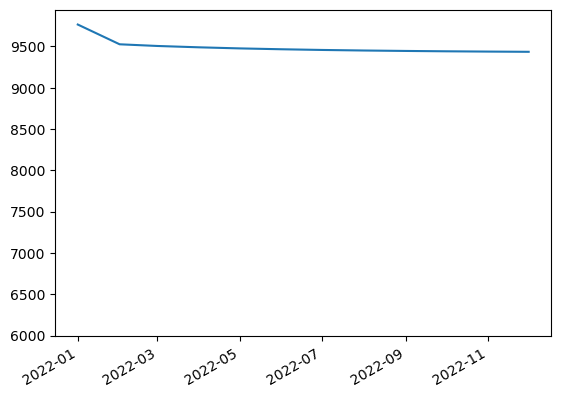

In [25]:
for i in forecast_all.columns:
    forecast_all[i].plot()

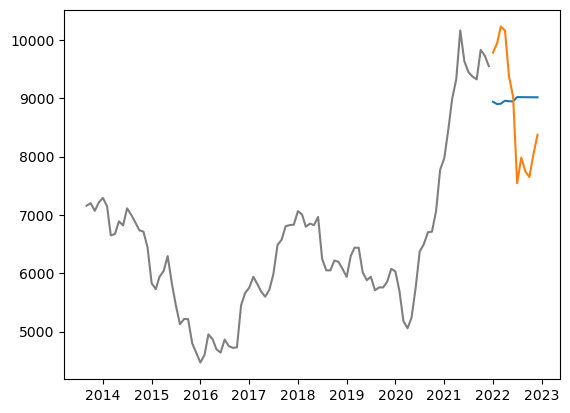

In [26]:
plt.plot(forecast_all.fillna(method='backfill').mean(axis=1))
plt.plot(y_test)
plt.plot(y_train.iloc[-100:])


# Moving average methods

In [27]:
copper = df['COPPER'].to_frame()

In [28]:
for i in range(2,12,1):
    copper['roll'+str(i)] = copper['COPPER'].rolling(i).mean()

In [29]:
copper

,COPPER,roll2,roll3,roll4,roll5,roll6,roll7,roll8,roll9,roll10,roll11
DATE,,,,,,,,,,,
1990-01-01,2366.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-01,2360.16,2363.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-03-01,2625.61,2492.885,2450.803333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-01,2686.15,2655.880,2557.306667,2509.6400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-01,2741.95,2714.050,2684.570000,2603.4675,2556.102,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,7981.84,7763.325,8183.703333,8482.0650,8817.928,9053.421667,9180.528571,9255.75500,9288.580000,9332.612,9377.758182
2022-09-01,7746.01,7863.925,7757.553333,8074.2800,8334.854,8639.275000,8866.648571,9001.21375,9088.005556,9134.323,9188.375455
2022-10-01,7651.08,7698.545,7792.976667,7730.9350,7989.640,8220.891667,8498.104286,8714.70250,8851.198889,8944.313,8999.482727


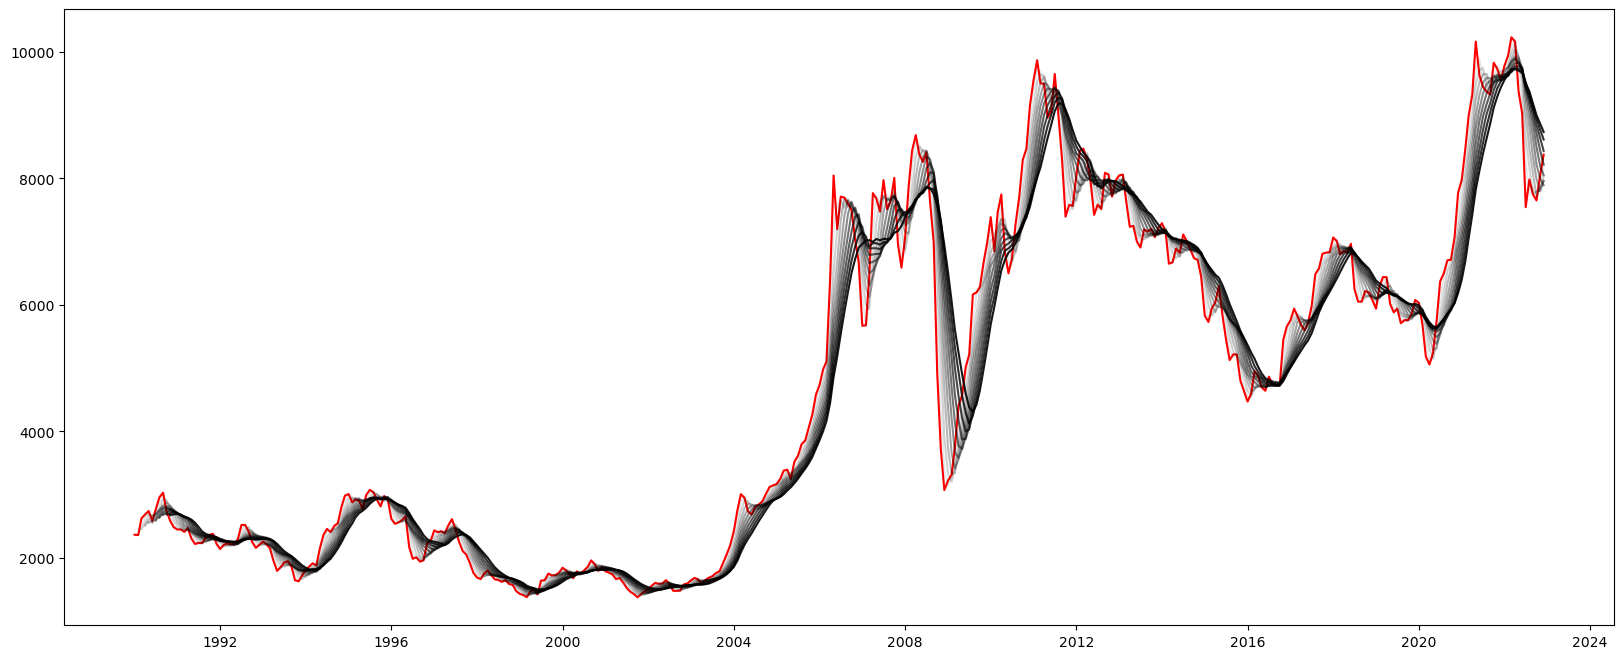

In [30]:
plt.figure(figsize=(20,8))
plt.plot(copper['COPPER'],c='red',label = 'Copper Monthly')
for i in range(1,len(copper.columns)):
    plt.plot(copper.iloc[:,i].dropna(), alpha=i/len(copper.columns),color='black',label=copper.iloc[:,i].name)
#plt.legend()

In [31]:
y_train, y_test = temporal_train_test_split(copper,test_size=12)
y_train = y_train
y_test = y_test

In [32]:
y_train

,COPPER,roll2,roll3,roll4,roll5,roll6,roll7,roll8,roll9,roll10,roll11
DATE,,,,,,,,,,,
1990-01-01,2366.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-01,2360.16,2363.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-03-01,2625.61,2492.885,2450.803333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-01,2686.15,2655.880,2557.306667,2509.6400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-01,2741.95,2714.050,2684.570000,2603.4675,2556.102,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,9370.14,9410.480,9484.153333,9653.6075,9587.850,9487.916667,9342.634286,9171.32375,9015.870000,8821.174,8629.595455
2021-09-01,9324.71,9347.425,9381.890000,9444.2925,9587.828,9543.993333,9464.601429,9340.39375,9188.366667,9046.754,8866.950000
2021-10-01,9829.22,9576.965,9508.023333,9493.7225,9521.278,9628.060000,9584.740000,9510.17875,9394.707778,9252.452,9117.887273


In [36]:
forecast_all = pd.DataFrame()
for j,i in enumerate(y_train.columns):
    forecaster = AutoETS(auto=True,freq='MS',damped_trend=True)
    forecaster.fit(y_train[i].dropna())
    horizon = pd.date_range(y_test.index[0],y_test.index[-1],freq='MS')[i::j]
    fh = ForecastingHorizon(y_test.index, is_relative=False,freq='M')
    forecastss = pd.Series(forecaster.predict(fh),index=y_test.index).rename(copper.columns[j])
    forecast_all = pd.concat([forecast_all,forecastss],axis=1)

ValueError: slice step cannot be zero

In [ ]:
forecast_all

In [ ]:
forecast_all.plot()

In [ ]:
plt.plot(forecast_all.mean(axis=1),label='forecast')
plt.plot(forecast_all['COPPER'],label='Montly ETS')
plt.plot(y_test['COPPER'],label='test')
plt.plot(y_train['COPPER'].iloc[-100:],label='train')
plt.legend();

In [37]:
forecast_all = pd.DataFrame()
for j,i in enumerate(y_train.columns):
    forecaster = AutoARIMA()
    forecaster.fit(y_train[i].dropna())
    #horizon = pd.date_range(y_test.index[0],y_test.index[-1],freq='MS')[i::j]
    fh = ForecastingHorizon(y_test.index, is_relative=False,freq='M')
    forecastss = pd.Series(forecaster.predict(fh),index=y_test.index).rename(copper.columns[j])
    forecast_all = pd.concat([forecast_all,forecastss],axis=1)

C:\Users\kosta\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kosta\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kosta\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\kosta\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kosta\anaconda3\lib\site-packages\statsmodels\tsa\states

TypeError: __new__() got an unexpected keyword argument 'freq'

In [ ]:
forecast_all

In [ ]:
plt.plot(forecast_all.mean(axis=1),label='forecast')
plt.plot(y_test['COPPER'],label='test')
plt.plot(forecast_all['COPPER'],label='Montly ARIMA')
plt.plot(y_train['COPPER'].iloc[-100:],label='train')
plt.legend();

In [38]:
forecast_all = pd.DataFrame()
for j,i in enumerate(y_train.columns):
    forecaster = NaiveForecaster('last')
    forecaster.fit(y_train[i].dropna())
    #horizon = pd.date_range(y_test.index[0],y_test.index[-1],freq='MS')[i::j]
    fh = ForecastingHorizon(y_test.index, is_relative=False,)
    forecastss = pd.Series(forecaster.predict(fh),index=y_test.index).rename(copper.columns[j])
    forecast_all = pd.concat([forecast_all,forecastss],axis=1)

C:\Users\kosta\anaconda3\lib\site-packages\sktime\forecasting\base\_fh.py:601: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:


AttributeError: The `freq` attribute of the time index is required, but found: None. Please specify the `freq` argument when setting the time index.